# Sea Surface Current Prediction using LSTM

This notebook outlines the process of loading, inspecting, and preprocessing sea surface current data (`u` and `v` components) for training an LSTM model. The goal is to predict sea surface currents for the next 24 hours based on historical data.

### Import Libraries

In [1]:
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load and Inspect Data

The initial step involves loading the dataset using xarray, which facilitates working with multi-dimensional arrays, and inspecting its structure to understand the available dimensions, coordinates, and variables.

In [2]:
# Load your dataset
file_path = 'Data/Processed_SSC_Data.nc'
ds = xr.open_dataset(file_path)

# Print dataset structure
print("Dataset structure:")
print(ds, "\n")
print("="*175)

# Extract latitude and longitude values directly from the dataset
lats = ds['lat'].values
lons = ds['lon'].values

# Print the extracted latitude and longitude values
print("\nExtracted latitude values:")
print(lats, "\n")
print("\nExtracted longitude values:")
print(lons, "\n")
print("="*175)

start_time = ds['time'].values[0]
end_time = ds['time'].values[-1]

# Print the start and end times from the dataset
print("\nDataset start time:", start_time, "\n")
print("Dataset end time:", end_time, "\n")
print("="*175)

# Create a time range for the predictions
times = pd.date_range(start=start_time, end=end_time, freq='H')

# Print the created time range for predictions
print("\nTime range:")
print(times, "\n")
print("="*175)

Dataset structure:
<xarray.Dataset>
Dimensions:  (time: 168, lat: 52, lon: 43)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 ... 2023-01-07T23:00:00
  * lat      (lat) float32 35.74 35.77 35.79 35.81 ... 36.81 36.84 36.86 36.88
  * lon      (lon) float32 13.68 13.72 13.76 13.8 ... 15.26 15.3 15.34 15.38
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  MRAG (measured);LICA (measured);SOPU (...
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 19:17:47
    NC_GLOBAL.grid_type:               REGULAR
    NC

## Data Preprocessing

Prepare the data for LSTM modeling, which involves several key steps:

1. Conversion to DataFrame: Convert the dataset to a pandas DataFrame for easier manipulation.
2. Handling NaN Values: Fill NaN values with the mean of each column.
3. Normalization: Scale the 'u' and 'v' features to a range between 0 and 1.
4. Sequence Creation: Generate input sequences for the LSTM model.
5. Train-Test Split: Divide the data into training, validation, and testing sets.

In [3]:
# Convert to DataFrame
df = ds.to_dataframe().reset_index()
print(f"DataFrame created with shape: {df.shape}")

# Handle NaN values by filling them with the mean of each column
df['u'] = df['u'].fillna(df['u'].mean())
df['v'] = df['v'].fillna(df['v'].mean())

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Assuming 'u' and 'v' are the features you want to normalize
features = df[['u', 'v']]
features_scaled = scaler.fit_transform(features)

# Replace 'u' and 'v' in df with their scaled versions
df[['u', 'v']] = features_scaled

# Define input_data and target_data
input_data = df[['u', 'v']]  # Features used for prediction
target_data = df[['u', 'v']]  # Targets to predict

DataFrame created with shape: (375648, 10)


### Create Sequences for LSTM

In [4]:
# Updated function to create sequences with a corresponding target sequence for the next 24 hours
def create_sequences(input_data, target_data, sequence_length, prediction_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length - prediction_length + 1):
        X.append(input_data.iloc[i:i+sequence_length].values)
        y.append(target_data.iloc[i+sequence_length:i+sequence_length+prediction_length].values)
    return np.array(X), np.array(y)

# Parameters for sequence creation
sequence_length = 24  # Use 24 hours of data to predict the next 24 hours
prediction_length = 24

X, y = create_sequences(input_data, target_data, sequence_length, prediction_length)
print(f"Sequences created. Input shape: {X.shape}, Target shape: {y.shape}")

Sequences created. Input shape: (375601, 24, 2), Target shape: (375601, 24, 2)


###  Train-Test Split

In [5]:
# Splitting the data into training (70%), and a temporary test set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Splitting the temporary test set equally into validation and test sets (50% of 30% -> 15% of the total data each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

print(f"Data split into training, validation, and testing sets. Training shape: {X_train.shape}, Validation shape: {X_val.shape}, Testing shape: {X_test.shape}\n")

# Check for NaNs or infinite values in the data
print(f"Training data contains NaN: {np.isnan(X_train).any() or np.isnan(y_train).any()}")
print(f"Validation data contains NaN: {np.isnan(X_val).any() or np.isnan(y_val).any()}")

Data split into training, validation, and testing sets. Training shape: (262920, 24, 2), Validation shape: (56340, 24, 2), Testing shape: (56341, 24, 2)

Training data contains NaN: False
Validation data contains NaN: False


### Hyperparameters

In [6]:
###

### Define LSTM Model Architecture

Define an LSTM model architecture for our time series forecasting problem. The model will consist of an LSTM layer followed by a Dense layer to predict the next 24 hours of `u` and `v` values based on the previous 24 hours.

In [7]:
# Define a simpler LSTM model
model = Sequential([
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True, input_shape=(24, 2))),
    Dropout(0.3),
    Bidirectional(LSTM(64, activation='tanh')),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(24 * 2)  # Predicting 24 hours ahead for both 'u' and 'v'
])

# Build the model
model.build(input_shape=(None, 24, 2))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 128)          34304     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

### Optimizer

In [8]:
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)

### Compile the Model

Compiling the model with an appropriate optimizer and loss function. Since this is a regression problem (predicting continuous `u` and `v` values), we will use the Mean Squared Error (MSE) loss function. The Adam optimizer will be used for its efficiency in handling sparse gradients and adaptive learning rates.


In [9]:
model.compile(optimizer=optimizer, loss='mean_squared_error')

### Train the Model

Training the model on the training set while validating its performance on the validation set. We will use a batch size of 64 and train for 50 epochs. Early stopping will be employed to halt training when the validation loss stops improving.

Epoch 1/100
2055/2055 [==============================] - 211s 99ms/step - loss: 0.0092 - val_loss: 0.0032
Epoch 2/100
2055/2055 [==============================] - 162s 79ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/100
2055/2055 [==============================] - 163s 79ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 4/100
2055/2055 [==============================] - 164s 80ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/100
2055/2055 [==============================] - 164s 80ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/100
2055/2055 [==============================] - 165s 80ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/100
2055/2055 [==============================] - 163s 79ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/100
2055/2055 [==============================] - 165s 80ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 9/100
2055/2055 [==============================] - 164s 80ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 10/100
2055/2055 [======================

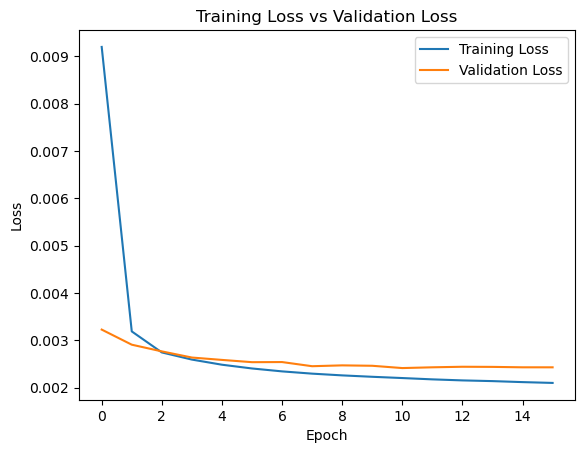

In [10]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    min_delta=0.00001,
    verbose=1,
    restore_best_weights=True 
)

# Define model checkpoint
model_checkpoint = ModelCheckpoint(
    'Saved_Models/best_model.h5', 
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0
)

# Fit the model with both callbacks
history = model.fit(
    X_train, y_train.reshape(y_train.shape[0], -1),
    epochs=100, batch_size=128,
    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)),
    callbacks=[early_stopping, model_checkpoint]
)

# Plotting code
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Evaluate the Model on Test Set

Finally, we will evaluate the model's performance on the test set to assess its generalization capability.

In [11]:
test_loss = model.evaluate(X_test, y_test.reshape(y_test.shape[0], -1), verbose=0)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Reshape y_test and y_pred as needed to calculate metrics
y_true = y_test.reshape(y_test.shape[0], -1)
y_pred = y_pred.reshape(y_pred.shape[0], -1)

# Calculate the different metrics
test_mse = mean_squared_error(y_true, y_pred)   # Lower is better. Range: [0, ∞), 0 being perfect.
test_mae = mean_absolute_error(y_true, y_pred)  # Lower is better. Range: [0, ∞), 0 being perfect.
test_rmse = np.sqrt(test_mse)                   # Lower is better. Range: [0, ∞), 0 being perfect.

# Print the metrics with explanations
print(f'\nTest Loss (MSE): {test_loss}')
print(f'Test MAE: {test_mae}')
print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}')
print("="*175)

1761/1761 [==============================] - 15s 8ms/step

Test Loss (MSE): 0.0029620875138789415
Test MAE: 0.028358663642661746
Test MSE: 0.0029620859638041
Test RMSE: 0.05442504904732838


# Making a Real Life Prediction

### Load Input NetCDF File and Convert to DataFrame

This file was extracted from the original dataset and will be used as input to the model to make predictions.

In [12]:
# Load the input NetCDF file (this file will be inputted into the model to make predictions)
input_ds = xr.open_dataset('Data/sea_surface_currents_input_for_prediction.nc')

# Convert file to DataFrame
input_df = input_ds.to_dataframe().reset_index()

### Preprocessing input file 

Similar steps as the training set: handle NaNs, normalize, create sequences


In [13]:
# Handle NaN values by filling them with the mean of each column
input_df['u'] = input_df['u'].fillna(input_df['u'].mean())
input_df['v'] = input_df['v'].fillna(input_df['v'].mean())

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize 'u' and 'v' features
features = input_df[['u', 'v']]
features_scaled = scaler.fit_transform(features)

# Replace 'u' and 'v' in input_df with their scaled versions
input_df[['u', 'v']] = features_scaled

###  Reshape Input Data for LSTM Model Prediction

In [14]:
# Extract the last 24-hour sequence of data for prediction
# Note: Adjust the slicing based on how your data is structured and how the model was trained
last_24_hours_df = input_df[-24:]

### ADD DEBUG

# Reshape data for the LSTM model input
# LSTM model was trained on 24-hour sequences with 2 features ('u' and 'v')
X_predict = last_24_hours_df[['u', 'v']].to_numpy().reshape(1, 24, 2)

### Make Predictions and Reshape Output

In [15]:
# Predict using the LSTM model
predicted_data = model.predict(X_predict, verbose=0)

# Inverse transform the prediction to the original scale
predicted_data_rescaled = scaler.inverse_transform(predicted_data.reshape(24, 2))

### Save output (predicted data) to netcdf

In [16]:
# Assuming you have the prediction dates, latitudes, and longitudes available
prediction_dates = pd.date_range(start="2023-06-02", periods=24, freq='h')
lats = input_ds['lat'].values  # Assuming input_ds is your input xarray Dataset
lons = input_ds['lon'].values

# Initialize arrays to hold the duplicated predictions
predicted_u_expanded = np.tile(predicted_data_rescaled[:, 0], (len(lats), len(lons), 1)).transpose((2, 0, 1))
predicted_v_expanded = np.tile(predicted_data_rescaled[:, 1], (len(lats), len(lons), 1)).transpose((2, 0, 1))

# Now, create the predicted_ds Dataset with the expanded predictions
predicted_ds = xr.Dataset(
    {
        "u": (("time", "lat", "lon"), predicted_u_expanded),
        "v": (("time", "lat", "lon"), predicted_v_expanded),
    },
    coords={
        "time": prediction_dates,
        "lat": lats,
        "lon": lons,
    }
)

file_path = 'Data/predicted_sea_surface_currents.nc'

# Save the predicted dataset to a NetCDF file
predicted_ds.to_netcdf(file_path)

# Load your dataset
predicted_ds_check = xr.open_dataset(file_path)

# Print dataset structure
print("Predicted Dataset structure:")
print(predicted_ds_check, "\n")
print("="*175)

Predicted Dataset structure:
<xarray.Dataset>
Dimensions:  (time: 24, lat: 52, lon: 43)
Coordinates:
  * time     (time) datetime64[ns] 2023-06-02 ... 2023-06-02T23:00:00
  * lat      (lat) float32 35.74 35.77 35.79 35.81 ... 36.81 36.84 36.86 36.88
  * lon      (lon) float32 13.68 13.72 13.76 13.8 ... 15.26 15.3 15.34 15.38
Data variables:
    u        (time, lat, lon) float32 ...
    v        (time, lat, lon) float32 ... 



# Compare Prediction to Actual Data

In [17]:
file_path_2 = 'Data/sea_surface_currents_compare_for_prediction.nc'

# Load the comparison file
compare_ds = xr.open_dataset(file_path_2)

# Output information to see if it is correct date and format
compare_ds_check = xr.open_dataset(file_path_2)

# Print dataset structure
print("Comparison File Dataset structure:")
print(compare_ds_check, "\n")
print("="*175)

Comarison File Dataset structure:
<xarray.Dataset>
Dimensions:  (time: 24, lat: 52, lon: 43)
Coordinates:
  * time     (time) datetime64[ns] 2023-06-02 ... 2023-06-02T23:00:00
  * lat      (lat) float32 35.74 35.77 35.79 35.81 ... 36.81 36.84 36.86 36.88
  * lon      (lon) float32 13.68 13.72 13.76 13.8 ... 15.26 15.3 15.34 15.38
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  BARK (measured);POZZ (measured);LICA (...
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 20:07:00
    NC_GLOBAL.grid_type:               

In [18]:
# Flatten the actual 'u' and 'v' values for comparison
actual_u = compare_ds['u'].values.flatten()
actual_v = compare_ds['v'].values.flatten()

# Flatten the predicted 'u' and 'v' values for comparison
predicted_u = predicted_ds['u'].values.flatten()
predicted_v = predicted_ds['v'].values.flatten()

# Filter out NaNs from actual_u and actual_v and their corresponding predictions
not_nan_mask_u = ~np.isnan(actual_u)
filtered_actual_u = actual_u[not_nan_mask_u]
filtered_predicted_u = predicted_u[not_nan_mask_u]

not_nan_mask_v = ~np.isnan(actual_v)
filtered_actual_v = actual_v[not_nan_mask_v]
filtered_predicted_v = predicted_v[not_nan_mask_v]

# Calculate error metrics for 'u' using filtered values
mse_u = mean_squared_error(filtered_actual_u, filtered_predicted_u)
mae_u = mean_absolute_error(filtered_actual_u, filtered_predicted_u)
rmse_u = np.sqrt(mse_u)

# Calculate error metrics for 'v' using filtered values
mse_v = mean_squared_error(filtered_actual_v, filtered_predicted_v)
mae_v = mean_absolute_error(filtered_actual_v, filtered_predicted_v)
rmse_v = np.sqrt(mse_v)

print(f"Error Metrics for 'u':\nMSE: {mse_u}\nMAE: {mae_u}\nRMSE: {rmse_u}\n")
print(f"Error Metrics for 'v':\nMSE: {mse_v}\nMAE: {mae_v}\nRMSE: {rmse_v}\n")

Error Metrics for 'u':
MSE: 0.039714498650188584
MAE: 0.15674909894979044
RMSE: 0.19928496845017837

Error Metrics for 'v':
MSE: 0.03234610213223287
MAE: 0.13829438228927649
RMSE: 0.17985022138499823



### Making comparisons for same location

In [19]:
selected_lon = 13.68
selected_lat = 35.74

print(f"Filtered Actual vs Predicted 'u' values for the first 24 hours at location (lon: {selected_lon}, lat: {selected_lat}):")
for i in range(24):
    # We need to check if we have enough data points after filtering
    if i < len(filtered_actual_u) and i < len(filtered_predicted_u):
        print(f"Hour {i+1}: Actual u: {filtered_actual_u[i]}, Predicted u: {filtered_predicted_u[i]}")
    else:
        print(f"Hour {i+1}: Not enough data points available after filtering for NaN values.")

print(f"\nFiltered Actual vs Predicted 'v' values for the first 24 hours at location (lon: {selected_lon}, lat: {selected_lat}):")
for i in range(24):
    if i < len(filtered_actual_v) and i < len(filtered_predicted_v):
        print(f"Hour {i+1}: Actual v: {filtered_actual_v[i]}, Predicted v: {filtered_predicted_v[i]}")
    else:
        print(f"Hour {i+1}: Not enough data points available after filtering for NaN values.")

Filtered Actual vs Predicted 'u' values for the first 24 hours at location (lon: 13.68, lat: 35.74):
Hour 1: Actual u: -0.07104788967975725, Predicted u: 0.0686665028333664
Hour 2: Actual u: -0.04782448141978448, Predicted u: 0.0686665028333664
Hour 3: Actual u: -0.014571334226734556, Predicted u: 0.0686665028333664
Hour 4: Actual u: 0.006820242418312718, Predicted u: 0.0686665028333664
Hour 5: Actual u: 0.009262624151131224, Predicted u: 0.0686665028333664
Hour 6: Actual u: 0.030540892678236085, Predicted u: 0.0686665028333664
Hour 7: Actual u: -0.07421332274404487, Predicted u: 0.0686665028333664
Hour 8: Actual u: -0.05912553329718562, Predicted u: 0.0686665028333664
Hour 9: Actual u: -0.036570216211938136, Predicted u: 0.0686665028333664
Hour 10: Actual u: -0.01091562718831708, Predicted u: 0.0686665028333664
Hour 11: Actual u: -0.010052023595182966, Predicted u: 0.0686665028333664
Hour 12: Actual u: 0.0011245187406154463, Predicted u: 0.0686665028333664
Hour 13: Actual u: -0.042935